## Full Model Terminal Wealth

In [ ]:
#Import relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
import time
import numpy as np
from scipy.integrate import quad_vec
import scipy.stats as si
import pygad
import torch
from tqdm import tqdm
import random
from scipy.optimize import minimize, differential_evolution
#from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.ndimage import uniform_filter1d
from scipy.interpolate import UnivariateSpline


In [232]:
# Enable LaTeX fonts in plots
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

In [233]:
# Seeds
MASTER_SEED = 42
np.random.seed(MASTER_SEED)
random.seed(MASTER_SEED)

# Seed PyTorch
torch.manual_seed(MASTER_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(MASTER_SEED)
    torch.cuda.manual_seed_all(MASTER_SEED) 


In [ ]:
#Parameters

#Simulation parameters
T = 1.0                 # Time horizon (years)
N = 252                 # Number of time steps
dt = T / N              # Time increment
M = 10000                # Number of Monte Carlo simulations

#Interest rate parameters
kappa_r= 0.13                                       # Speed of mean reversion for interest rate                             # Escobar
varphi_r=0.0025                                     # Varphi_r/kappa_r is the long term mean of the interest rate           # Escobar
print("varphi_r/kappa_r: ", varphi_r / kappa_r)     # Varphi_r/kappa_r is the long term mean of the interest rate           # Escobar
sigma_r= 0.0566                                     # Volatility of the interest rate                                       # Escobar
r0 = varphi_r / kappa_r                             # Initial interest rate                                                 # Escobar

#Bond parameters
lambda_r = -0.1132                                  # Risk premium on interest rate                                         # Escobar
T_tilde = T                                         # Bond maturity

#Stock and variance 

# Parameters for Heston volatility process
kappa_v = 2.8278                                    # Speed of mean reversion for variance                                  # Escobar
varphi_v= 0.0563                                    # varphi_v/kappa_v is the long-run variance                             # Escobar
print("varphi_v/kappa_v: ", varphi_v / kappa_v)     # varphi_v/kappa_v is the long-run variance                             # Escobar
sigma_v = 0.2941                                    # Volatility of variance process                                        # Escobar
V0 = varphi_v / kappa_v                             # Initial variance                                                      # Escobar    
rho = -0.23                                         # Correlation between stock and variance shocks                         # Escobar                                  
lambda_v= -6.6932                                   # Risk premium on variance                                              # Escobar                 

# Parameters for stock price process
S0 = 100                                            # Initial stock price                                                   # Escobar
lambda_s = 2.2472                                   # Risk premium on diffusive risk                                        # Escobar                        
nu=-0.5973                                          # Factor loading stock and rate                                         # Escobar 
lambda_j =12.3                                     # Jump intensity                                                         # Pan
lambda_j_q = lambda_j*2                             # Jump intensity Q                                                      # Liu and Pan
mu= -0.10                                           # Jump amplitude                                                        # Liu and Pan

# Parameters for jump process
lambda_J = 0.5                                      # Jump frequency                                                        # Liu and Pan

# Parameters for option pricing 
num_K= 9                                            # Number of strikes         

# General parameters
gamma= 3                                            # Risk aversion parameter                                              # Liu and Pan

varphi_r/kappa_r:  0.019230769230769232
varphi_v/kappa_v:  0.019909470259565742


In [235]:
# Function for b(T-t)
def b_func(T_tilde, t, kappa_r, lambda_r):
    xi = np.sqrt((kappa_r + lambda_r) ** 2 + 2 * sigma_r ** 2)
    exp_term = np.exp(xi * (T_tilde - t)) - 1
    num = 2 * exp_term
    den = 2 * xi + (xi + kappa_r + lambda_r) * exp_term

    if np.isnan(num) or np.isnan(den) or den == 0:
        return 0.0

    return num / den

In [236]:
print("Expected return on stock: ", r0+lambda_v*rho*V0+lambda_s*np.sqrt(1-rho**2)*V0+nu*lambda_r*r0+mu*(lambda_j-lambda_j_q)*V0)
print("Expected return on bond: ", r0-lambda_r*b_func(1,0,kappa_r,lambda_r)*r0)

Expected return on stock:  0.11921014430729271
Expected return on bond:  0.021388365884807477


In [237]:
def simulation(S0, V0, r0):

    # Initialize arrays
    S_paths = np.zeros((M, N + 1))
    V_paths = np.zeros((M, N + 1))
    r_paths = np.zeros((M, N + 1))
    dN = np.zeros((M, N + 1))
    B = np.zeros((M, N + 1))
    M_t = np.zeros((M, N + 1))
    sqrt_1_minus_rho2 = np.sqrt(1 - rho ** 2)
    dW_r = np.random.normal(0, np.sqrt(dt), size=(M, N + 1))
    dW_v = np.random.normal(0, np.sqrt(dt), size=(M, N + 1))
    dW_s = np.random.normal(0, np.sqrt(dt), size=(M, N + 1))
    N_J = np.random.poisson(lambda_J * dt, size=(M, N + 1))

    # Initial values
    S_paths[:, 0] = S0
    V_paths[:, 0] = V0
    r_paths[:, 0] = r0
    B[:, 0] = 1
    M_t[:, 0] = 1

    # Store means
    mean_S = [np.mean(S0)]
    mean_V = [np.mean(V0)]
    mean_r = [np.mean(r0)]
    mean_M = [1.0]
    mean_B = [1.0]

    for j in range(1, N + 1):
        S_prev = S_paths[:, j - 1]
        V_prev = V_paths[:, j - 1]
        r_prev = r_paths[:, j - 1]

        # CIR (interest rate)
        r_new = r_prev + (varphi_r - kappa_r * r_prev) * dt + sigma_r * np.sqrt(np.maximum(r_prev, 0)) * dW_r[:, j]
        r_new = np.maximum(r_new, 0)

        # Heston (volatility)
        V_new = V_prev + (varphi_v - kappa_v * V_prev) * dt + sigma_v * np.sqrt(np.maximum(V_prev, 0)) * dW_v[:, j]
        V_new = np.maximum(V_new, 0)

        # Stock diffusion
        diffusion = np.sqrt(V_prev) * (rho * dW_v[:, j] + sqrt_1_minus_rho2 * dW_s[:, j]) * S_prev \
                    + nu * sigma_r * np.sqrt(r_prev) * dW_r[:, j] * S_prev

        # Jump component
        jump_term = S_prev * mu * (N_J[:, j] - lambda_j * V_prev * dt)

        # Drift
        drift = (
            r_prev
            + lambda_v * rho * V_prev
            + lambda_s * sqrt_1_minus_rho2 * V_prev
            + nu * lambda_r * r_prev
            + mu * (lambda_j - lambda_j_q) * V_prev
        ) * S_prev * dt

        # Stock price update
        S_new = S_prev + drift + diffusion + jump_term

        # Money market account
        M_t[:, j] = M_t[:, j - 1] * np.exp(r_prev * dt)

        # Bond process
        t_curr = j * dt
        b_T_t = b_func(T_tilde, t_curr, kappa_r, lambda_r)
        drift_B = (r_prev - lambda_r * b_T_t * r_prev) * B[:, j - 1] * dt
        diffusion_B = -b_T_t * sigma_r * np.sqrt(r_prev) * B[:, j - 1] * dW_r[:, j]
        B[:, j] = B[:, j - 1] + drift_B + diffusion_B

        # Store new values
        S_paths[:, j] = S_new
        V_paths[:, j] = V_new
        r_paths[:, j] = r_new


        mean_S.append(np.mean(S_new))
        mean_V.append(np.mean(V_new))
        mean_r.append(np.mean(r_new))
        mean_M.append(np.mean(M_t[:, j]))
        mean_B.append(np.mean(B[:, j]))

    return mean_S, mean_V, mean_r, mean_M, mean_B, dW_s, dW_v, dW_r, N_J

In [238]:
def compute_k1_k2_k3_vol(gamma, lambda_v, lambda_s, sigma_v, kappa_v, lambda_j_q, lambda_j):
    k1_v = kappa_v - (1 - gamma) / gamma * (lambda_v* sigma_v) 
    k3_v=(lambda_v**2 + lambda_s**2) * ((1 - gamma) / (gamma))+lambda_j_q*(gamma*(lambda_j/lambda_j_q)**(1/gamma)+(1-gamma)-(lambda_j/lambda_j_q))
    k4_v=sigma_v**2/gamma
    k2_v = np.sqrt(k1_v**2 - k3_v*k4_v)
    return k1_v, k2_v, k3_v

def compute_k1_k2_k3_rate(gamma, lambda_r, sigma_r, kappa_r):
    k1_r = kappa_r - ((1 - gamma) *(lambda_r))/ gamma 
    k3_r=2*(1-gamma)+(lambda_r**2*(1-gamma))/(gamma*sigma_r**2)
    k4_r=sigma_r**2/gamma
    k2_r = np.sqrt(k1_r**2 - k3_r*k4_r)
    return k1_r, k2_r, k3_r

def H_v(tau, k1_v, k2_v, k3_v):
    denominator = 2 * k2_v + (k1_v + k2_v) * (np.exp(k2_v * tau) - 1)
    H_v_star = ((np.exp(k2_v*tau)-1) / denominator)*k3_v
    return H_v_star

def H_r(tau, k1_r, k2_r, k3_r):
    denominator = 2 * k2_r + (k1_r + k2_r) * (np.exp(k2_r * tau) - 1)
    H_r_star = ((np.exp(k2_r*tau)-1) / denominator)*k3_r
    return H_r_star

def theta_cal(gamma, lambda_s, lambda_v, lambda_r, sigma_v, sigma_r, k1_r, k2_r, k3_r,k1_v, k2_v, k3_v, mu, lambda_j, lambda_j_q, tau):
    theta_s=lambda_s/gamma
    theta_v=lambda_v/gamma+1/gamma*sigma_v*H_v(tau, k1_v, k2_v, k3_v)
    theta_r=lambda_r/(sigma_r**2*gamma)+1/gamma*H_r(tau, k1_r, k2_r, k3_r)
    theta_N=1/mu* ((lambda_j/lambda_j_q)**(1/gamma)-1)
    return theta_s, theta_v, theta_r, theta_N


def pi_calc(theta_s, theta_v, theta_r, theta_N, A1_1, A2_1, A3_1, A4_1,A1_2, A2_2, A3_2, A4_2 ,T_tilde,t,kappa_r,lambda_r, mu,rho, nu):
    b_val = float(b_func(T_tilde, t, kappa_r, lambda_r))
    
    A = np.array([
    [np.sqrt(1 - rho**2), 0, A1_1, A1_2],
    [nu, -b_val*100, A2_1, A2_2],
    [rho, 0, A3_1, A3_2],
    [1, 0, (1/mu)*(A4_1), (1/mu)*(A4_2)]])

    theta = np.array([theta_s, theta_r, theta_v, theta_N], dtype=float)

    row_norms = np.linalg.norm(A, axis=1, keepdims=True)
    A = A / row_norms
    theta = theta / row_norms.squeeze()

    try:
        pi = np.linalg.solve(A, theta)
    except np.linalg.LinAlgError:
        pi = np.linalg.pinv(A) @ theta

    pi_s = pi[0]
    pi_b = pi[1]
    pi_o1 = pi[2]
    pi_o2 = pi[3]
    pi_mm = 1 - pi_s - pi_b - pi_o1 - pi_o2

    return pi_s, pi_b, pi_o1, pi_o2, pi_mm

In [ ]:
def simulate_wealth(
    kappa_r,S_np, V_np, r_np, M_t, B_np, dW_s_np, dW_v_np, dW_r_np, N_J,
    gamma, lambda_v, lambda_r, sigma_r, kappa_v, sigma_v, T,
    lambda_s, lambda_j, lambda_j_q, mu, tau
):

    N_sim = len(S_np) - 1  # Since it's a time series of means

    dt = T / N_sim

    # Initialize wealth vectors
    X_opt = 1
    X_6040 = 1

    # Compute constants and risk premia
    k1_v, k2_v, k3_v = compute_k1_k2_k3_vol(gamma, lambda_v, lambda_s, sigma_v, kappa_v, lambda_j_q, lambda_j)
    k1_r, k2_r, k3_r = compute_k1_k2_k3_rate(gamma, lambda_r, sigma_r, kappa_r)

    theta_s, theta_v, theta_r, theta_N = theta_cal(
        gamma, lambda_s, lambda_v, lambda_r, sigma_v, sigma_r,
        k1_r, k2_r, k3_r, k1_v, k2_v, k3_v,
        mu, lambda_j, lambda_j_q, tau
    )

    pi_s_6040, pi_b_6040 = 0.6, 0.4

    # Simulate wealth paths
    for t in range(N_sim):
        
        V_t = np.maximum(V_np[t], 0)
        r_t = np.maximum(r_np[t], 0)

        sqrt_V_t = np.sqrt(V_t)
        sqrt_r_t = np.sqrt(r_t)

        dW_s_t = dW_s_np[:, t]
        dW_v_t = dW_v_np[:, t]
        dW_r_t = dW_r_np[:, t]
        dN_t = N_J[:, t]

        drift_opt = (
            r_t * dt +
            theta_s * (lambda_s * V_t * dt + sqrt_V_t * dW_s_t) +
            theta_v * (lambda_v * V_t * dt + sqrt_V_t * dW_v_t) +
            theta_r * (lambda_r * r_t * dt + sigma_r * sqrt_r_t * dW_r_t) +
            theta_N  * mu *((lambda_j - lambda_j_q) * V_t * dt + (dN_t - lambda_j * V_t * dt))
        )

        dS_rel = (S_np[t + 1] - S_np[t]) / S_np[t]
        dB_rel = (B_np[t + 1] - B_np[t]) / B_np[t]
        drift_6040 = pi_s_6040 * dS_rel + pi_b_6040 * dB_rel

        X_opt *= (1 + drift_opt)
        X_6040 *= (1 + drift_6040)

    return X_opt, X_6040


In [ ]:
S_paths, V_paths, r_paths, M_t, B, dW_s, dW_v, dW_r, N_J = simulation(S0, V0, r0)

In [ ]:
T_tilde = 1
t_curr=T_tilde - 1/12
tau = T_tilde - t_curr

gamma_vals     = np.linspace(1.5, 10, 100)   
lambda_s_vals  = np.linspace(-10, 10, 100)
lambda_v_vals  = np.linspace(-10, 10, 100)
lambda_r_vals  = np.linspace(-0.25, 0.25, 100)     
lambda_ratios   = np.linspace(1.0, 5.0, 100)
tau_vals       = np.linspace(1/12, 36/12, 100) 

Looping over lambda_j_q: 100%|██████████| 100/100 [00:04<00:00, 20.85it/s]


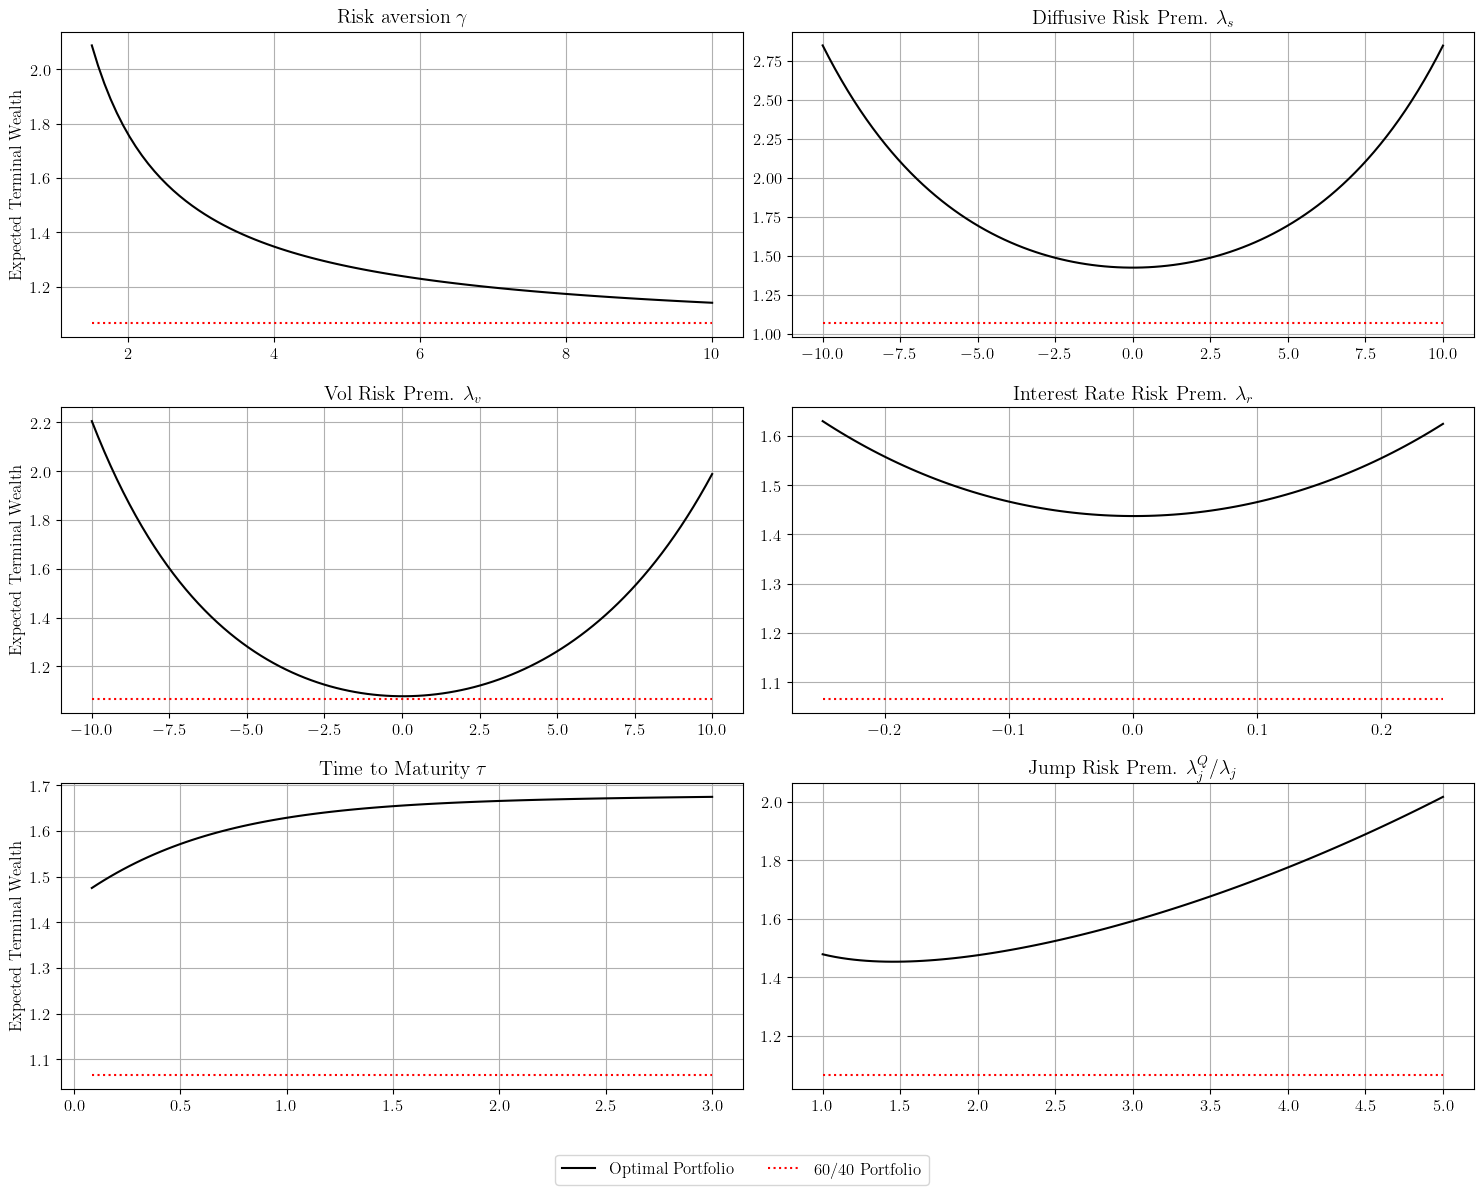

In [ ]:
# Define styles
style_dict = {
    "expected_X_opt": {"color": "black", "linestyle": "-"},
    "expected_X_6040": {"color": "red", "linestyle": ":"}, 
    "expected_X_no_option": {"color": "blue", "linestyle": "--"},
}

def plot_all(ax, x, s, b, xlabel, title, add_ylabel=False):
    ax.plot(x, s, label='Optimal Portfolio', **style_dict["expected_X_opt"])
    ax.plot(x, b, label='60/40 Portfolio', **style_dict["expected_X_6040"])
    ax.set_title(title)
    if add_ylabel:
        ax.set_ylabel("Expected Terminal Wealth")
    ax.grid(True)

sweep_config = {
    "gamma": (gamma_vals, r"$\gamma$", r"Risk aversion $\gamma$"),
    "lambda_s": (lambda_s_vals, r"$\lambda_s$", r"Diffusive Risk Prem. $\lambda_s$"),
    "lambda_v": (lambda_v_vals, r"$\lambda_v$", r"Vol Risk Prem. $\lambda_v$"),
    "lambda_r": (lambda_r_vals, r"$\lambda_r$", r"Interest Rate Risk Prem. $\lambda_r$"),
    "tau": (tau_vals, r"$\tau$", r"Time to Maturity $\tau$"),
    "lambda_j_q": (lambda_ratios, r"$\lambda_j^Q$ / $\lambda_j$", r"Jump Risk Prem. $\lambda_j^Q$/$\lambda_j$"),
}

results = {}

for param_name, (param_vals, _, title) in sweep_config.items():
    expected_X_opt = []
    expected_X_6040 = []
    
    for val in tqdm(param_vals, desc=f"Looping over {param_name}"):
        local_params = {
            "lambda_r": lambda_r,
            "lambda_s": lambda_s,
            "lambda_v": lambda_v,
            "sigma_r": sigma_r,
            "gamma": gamma,
            "tau": tau,
            "lambda_j_q": lambda_j_q,
        }
        if param_name == "lambda_j_q":
            local_params["lambda_j"] = lambda_j
            local_params["lambda_j_q"] = val * lambda_j
        else:
            local_params[param_name] = val

        T_tilde_loop = local_params["tau"] + t_curr if param_name == "tau" else T_tilde
    

        X_opt, X_6040 = simulate_wealth(
            kappa_r, S_paths, V_paths, r_paths, M_t, B, dW_s, dW_v, dW_r, N_J,
            local_params["gamma"], local_params["lambda_v"], local_params["lambda_r"], local_params["sigma_r"], kappa_v, sigma_v, T,
            local_params["lambda_s"], lambda_j, local_params["lambda_j_q"], mu, local_params["tau"]
        )

        expected_X_opt.append(np.mean(X_opt))
        expected_X_6040.append(np.mean(X_6040))


    results[param_name] = {
        "vals": param_vals,
        "opt": expected_X_opt,
        "6040": expected_X_6040
    }

fig, axs = plt.subplots(3, 2, figsize=(15, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

param_order = list(sweep_config.keys())

for ax, param_name, add_ylabel in zip(axs.flat, param_order, [True, False, True, False, True, False]):
    x_vals, xlabel, title = sweep_config[param_name]
    s = results[param_name]["opt"]
    b = results[param_name]["6040"]
    plot_all(ax, x_vals, s, b, xlabel, title, add_ylabel=add_ylabel)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, frameon=True)

plt.tight_layout(rect=[0, 0.05, 1, 1]) 
plt.savefig("Full_model_terminal_wealth.png", dpi=600) 
plt.show()
